## File: occupations_DAG_edsl.ipynb
#### Summary: This notebook creates DAG for a given occupation.

#### By: Peyman Shahidi
#### First Created: June 15, 2024

#### Last Edit by Peyman on June 25, 2024

In [1]:
#Python
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
import requests
import re

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'
    output_path = f'{main_folder_path}/output/daily_tasks_occupations_analysis'

# Functions

In [3]:
def create_adjacency_matrix(adjacency_matrix_df):
    # keep names for node labels
    tasks = adjacency_matrix_df.columns.tolist()
    tasks = [x.split()[0] for x in tasks]
    node_labels = {value: index for value, index in enumerate(tasks)}
    print(node_labels) 

    # convert adjacency matrix to numpy array for graph depiction
    adjacency_matrix = adjacency_matrix_df.values
    adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)
    return adjacency_matrix

In [4]:
def draw_dag_line(occupation, focal_task, all_tasks):
    tasks = copy.deepcopy(all_tasks)
    tasks.remove(focal_task)
    q = QuestionCheckBox(
        question_name = "dag",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider this task: {{ task }}. 
            Of the following tasks, which task is this task an input to?
            Check all that apply.
            """),
        question_options = tasks
    )
    scenario = Scenario({'occupation':occupation, 'task': focal_task})
    return q.by(m4).by(scenario).run()


def dict_to_matrix(dictionary):
    from collections import OrderedDict

    # Use OrderedDict to maintain the insertion order of keys
    unique_keys = OrderedDict.fromkeys(dictionary.keys())
    unique_values = OrderedDict.fromkeys(val for values in dictionary.values() for val in values)
    
    # Combine keys and values into a single list while maintaining their order
    all_labels = list(unique_keys) + [val for val in unique_values if val not in unique_keys]
    
    # Create an index map for the labels
    label_index = {label: idx for idx, label in enumerate(all_labels)}
    
    # Initialize the matrix with zeros
    size = len(all_labels)
    matrix = np.zeros((size, size), dtype=int)
    
    # Populate the matrix
    for key, values in dictionary.items():
        i = label_index[key]
        for value in values:
            j = label_index[value]
            matrix[i][j] = 1
    
    return matrix, all_labels



def create_dag(occupation, tasks):
    dag = dict({})
    for task in tasks: 
        dag[task] = draw_dag_line(occupation, task, tasks).select("dag").first()

    # Convert DAG from dictionary to matrix
    dag_matrix, dag_matrix_labels = dict_to_matrix(dag)

    return dag, dag_matrix, dag_matrix_labels



def export_DAG_matrix_to_csv(matrix, labels, filename):
    # Create a DataFrame from the matrix
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    
    # Export the DataFrame to a CSV file
    df.to_csv(filename)

## Occupation Information

In [5]:
occupation = 'travelAgents'
GPT_input_occupation = 'Travel agent'
plot_title_occupation = 'Travel Agents'


# occupation = 'pileDriverOperators'
# GPT_input_occupation = 'Pile dirver operator'
# plot_title_occupation = 'Pile Driver Operators'


# occupation = 'insuranceUnderwriters'
# GPT_input_occupation = 'Insurance underwriter'
# plot_title_occupation = 'Insurance Underwriters'


# occupation = 'shampooers'
# GPT_input_occupation = 'Shampooer'
# plot_title_occupation = 'Shampooers'

## Node Positions for Graphs

In [6]:
def graph_node_positions(position, occupation):
    
    if occupation == 'travelAgents':
        pos[0] = (0, 0.0025) # Collect
        pos[1] = (-1.75, -0.005) # Converse
        pos[2] = (-.75, 0.0025) # Compute
        pos[3] = (0.5, 0) # Book 
        pos[4] = (-1.25, 0) # Plan
        pos[5] = (-1.75, 0.005) # Provide
        pos[6] = (1, 0.005) # Print
        pos[7] = (1, -0.005) # Record
        pos[8] = (1.5, 0) # Sink
        
    elif occupation == 'pileDriverOperators':
        pos[0] = (.25, .05) # Move hand
        pos[1] = (-1, 0) # Conduct
        pos[2] = (1, 0) # Drive
        pos[3] = (0.25, .02) # Move levers
        pos[4] = (-.5, 0) # Clean

    elif occupation == 'insuranceUnderwriters':
        pos[0] = (0.5, .1) # Decline
        pos[1] = (0, 0) # Write
        pos[2] = (0.25, -0.2) # Evaluate
        pos[3] = (0.5, 0) # Decrease 
        pos[4] = (0.25, 0.2) # Review
        pos[5] = (0.5, -.1) # Authorize
        pos[6] = (-.25, 0) # Examine
        pos[7] = (0.75, 0) # Sink

    elif occupation == 'shampooers':
        pos[0] = (0.25, -0.005) # Massage
        pos[1] = (0, 0) # Advise
        pos[2] = (0.25, 0.005) # Treat
        pos[3] = (0.5, 0) # Maintain

    return pos

## Occupation DAG - Manual Version

In [7]:
# Read the adjacency matrix
file_path = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
adjacency_matrix = pd.read_csv(f'{file_path}/{occupation}_AM.csv', index_col=0)

# keep names for node labels
tasks = adjacency_matrix.columns.tolist()
node_labels = []
for task in tasks:
    # Check if the string starts with "Move"
    if task.startswith("Move"):
        # If it does, keep the first two words
        modified_task = ' '.join(task.split()[:2])
    else:
        # Otherwise, keep the first two words as is
        modified_task = task.split()[0]
    # Add the modified string to the new list
    node_labels.append(modified_task)
node_labels = {value: index for value, index in enumerate(node_labels)}
print(node_labels)

# convert adjacency matrix to numpy array for graph depiction
adjacency_matrix = adjacency_matrix.values
adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)

{0: 'Collect', 1: 'Converse', 2: 'Compute', 3: 'Book', 4: 'Plan,', 5: 'Provide', 6: 'Print', 7: 'Record', 8: '"Sink"'}


## Occupation DAG - GPT Version

In [9]:
import copy
import random

from edsl.questions import QuestionCheckBox, QuestionFreeText
from edsl import Scenario, Model
from edsl.questions import QuestionMultipleChoice
from itertools import combinations
from edsl.questions.derived.QuestionLinearScale import QuestionLinearScale
from textwrap import dedent

Model.available()
m35 = Model('gpt-3.5-turbo')
m4 = Model('gpt-4o')

In [10]:
# Prompts GPT and create DAG
if '"Sink"' in tasks:
    tasks.remove('"Sink"')
GPT_dag_dict, GPT_dag_matrix, GPT_dag_matrix_labels = create_dag(GPT_input_occupation, tasks)

# Save GPT DAG output
filename = f'{data_path}/daily_tasks_occupations_analysis/{occupation}/{occupation}_GPT_DAG.csv'
export_DAG_matrix_to_csv(GPT_dag_matrix, GPT_dag_matrix_labels, filename)

# create dictionary of node labels for plotting
node_labels = []
for task in tasks:
    # Check if the string starts with "Move"
    if task.startswith("Move"):
        # If it does, keep the first two words
        modified_task = ' '.join(task.split()[:2])
    else:
        # Otherwise, keep the first two words as is
        modified_task = task.split()[0]
    # Add the modified string to the new list
    node_labels.append(modified_task)
node_labels = {value: index for value, index in enumerate(node_labels)}
print(node_labels)

{0: 'Collect', 1: 'Converse', 2: 'Compute', 3: 'Book', 4: 'Plan,', 5: 'Provide', 6: 'Print', 7: 'Record'}


## Compare DAGs: Manual vs. GPT

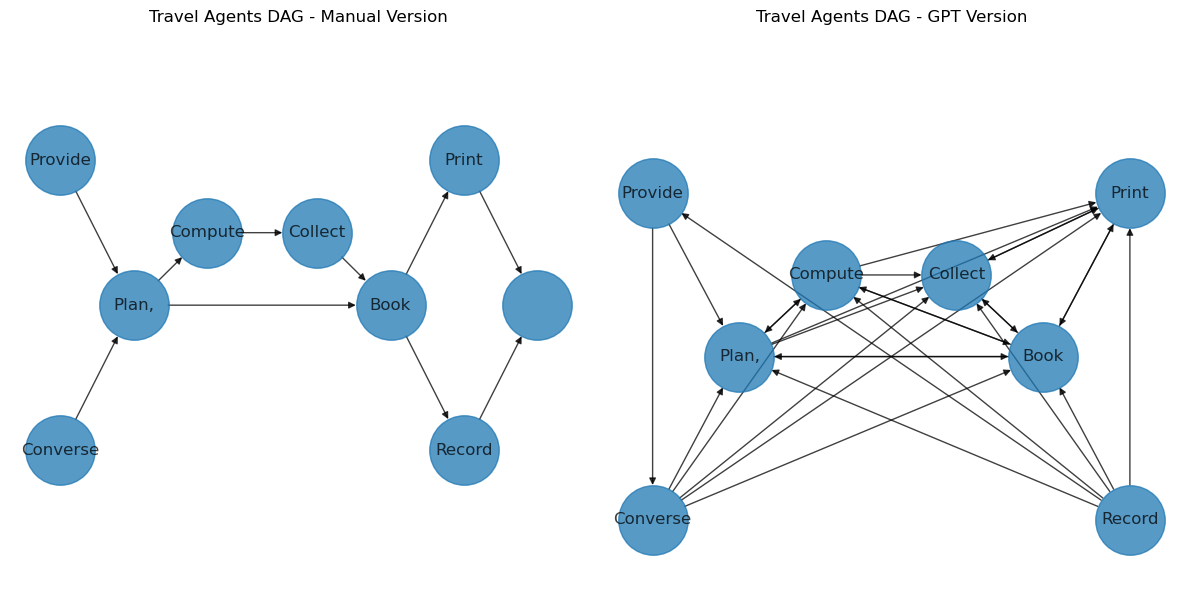

In [12]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw Manual version
G1 = nx.DiGraph(adjacency_matrix)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG - Manual Version')

# Draw GPT version
G2 = nx.DiGraph(GPT_dag_matrix)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} DAG - GPT Version')

# Adjust layout and save
plt.tight_layout()
#plt.savefig(f'{file_path}/{occupation}_DAG.png')

In [13]:
# remove the sink node from Manual version if it's present
if adjacency_matrix.shape[0] != GPT_dag_matrix.shape[0]:
    adjacency_matrix = adjacency_matrix[:-1,:-1]

In [14]:
# Subtract the GPT matrix from Manual
diff_matrix = adjacency_matrix - GPT_dag_matrix

# subset edges which are in Manual DAG but not in GPT's
inManual_notInGPT = diff_matrix.copy()
inManual_notInGPT[inManual_notInGPT < 0] = 0

# subset edges which are in GPT's DAG but not in Manual's
inGPT_notInManual = diff_matrix.copy()
inGPT_notInManual[inGPT_notInManual > 0] = 0
inGPT_notInManual[inGPT_notInManual < 0] = 1

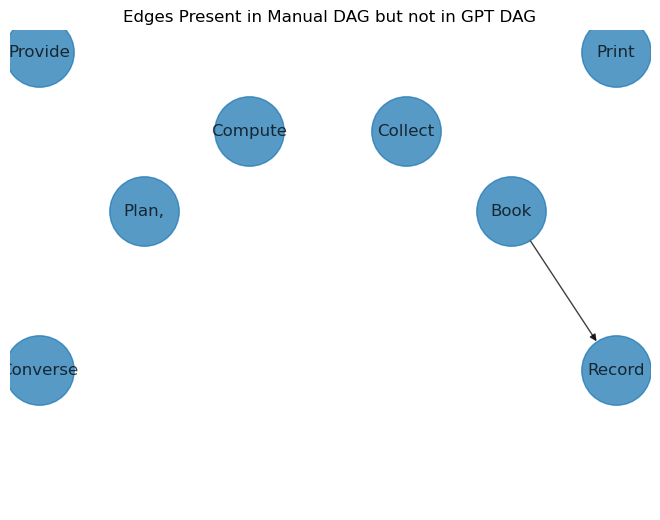

In [15]:
# Create a directed graph from the adjacency matrix
G = nx.DiGraph(inManual_notInGPT)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions
pos = graph_node_positions(pos, occupation)

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
plt.title("Edges Present in Manual DAG but not in GPT DAG")
plt.savefig(f'{file_path}/{occupation}_inManual_notInGPT.png')

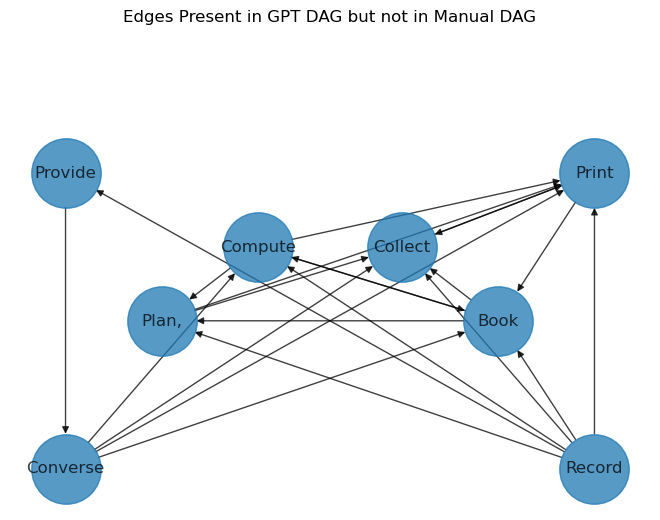

In [16]:
# Create a directed graph from the adjacency matrix
G = nx.DiGraph(inGPT_notInManual)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions
pos = graph_node_positions(pos, occupation)

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
plt.title("Edges Present in GPT DAG but not in Manual DAG")
plt.savefig(f'{file_path}/{occupation}_inGPT_notInManual.png')

## Task Relationships - Precedence Matrix (PM)

In [17]:
def task_relationships(occupation, tasks):
    #random.shuffle(tasks)
    scenarios = [Scenario({"occupation": occupation, "task_A": task_A, "task_B": task_B}) 
        for task_A, task_B in combinations(tasks, 2)]

    q = QuestionMultipleChoice(
        question_name = "ordering",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider these two tasks: 
            A) {{ task_A }} 
            B) {{ task_B }}
            What is the relationship between these tasks?
            """),
        question_options = [
            "A would be done first", 
            "B would be done first", 
            "Could be done in either order, but still part of the same task", 
            "Not part of the same task sequence"]
    )
    results = q.by(m4).by(scenarios).run(progress_bar = True)
    return results

results = task_relationships("Prile driver operator", tasks)
results.select("task_A", "task_B", "ordering").print()

Output()

scenario.task_A,scenario.task_B,answer.ordering
Collect payment for transportation and accommodations from customer.,"Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.",B would be done first
Collect payment for transportation and accommodations from customer.,"Compute cost of travel and accommodations, using calculator, computer, carrier tariff books, and hotel rate books, or quote package tour's costs.",B would be done first
Collect payment for transportation and accommodations from customer.,"Book transportation and hotel reservations, using computer or telephone.",B would be done first
Collect payment for transportation and accommodations from customer.,"Plan, describe, arrange, and sell itinerary tour packages and promotional travel incentives offered by various travel carriers.",B would be done first
Collect payment for transportation and accommodations from customer.,"Provide customer with brochures and publications containing travel information, such as local customs, points of interest, or foreign country regulations.",Not part of the same task sequence
Collect payment for transportation and accommodations from customer.,"Print or request transportation carrier tickets, using computer printer system or system link to travel carrier.",A would be done first
Collect payment for transportation and accommodations from customer.,"Record and maintain information on clients, vendors, and travel packages.",B would be done first
"Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.","Compute cost of travel and accommodations, using calculator, computer, carrier tariff books, and hotel rate books, or quote package tour's costs.",A would be done first
"Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.","Book transportation and hotel reservations, using computer or telephone.",A would be done first
"Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.","Plan, describe, arrange, and sell itinerary tour packages and promotional travel incentives offered by various travel carriers.",A would be done first


In [18]:
# Convert results to pandas df
df = results.select("task_A", "task_B", "ordering").to_pandas()

# Sort df on task_A column so it follows the tasks list order
df['scenario.task_A'] = pd.Categorical(df['scenario.task_A'], categories=tasks, ordered=True)

# Sort the DataFrame based on column 'scenario.task_A'
df = df.sort_values('scenario.task_A')
df

,answer.ordering,scenario.task_A,scenario.task_B
0,B would be done first,Collect payment for transportation and accommo...,Converse with customer to determine destinatio...
1,B would be done first,Collect payment for transportation and accommo...,"Compute cost of travel and accommodations, usi..."
2,B would be done first,Collect payment for transportation and accommo...,"Book transportation and hotel reservations, us..."
3,B would be done first,Collect payment for transportation and accommo...,"Plan, describe, arrange, and sell itinerary to..."
4,Not part of the same task sequence,Collect payment for transportation and accommo...,Provide customer with brochures and publicatio...
5,A would be done first,Collect payment for transportation and accommo...,Print or request transportation carrier ticket...
6,B would be done first,Collect payment for transportation and accommo...,"Record and maintain information on clients, ve..."
7,A would be done first,Converse with customer to determine destinatio...,"Compute cost of travel and accommodations, usi..."
8,A would be done first,Converse with customer to determine destinatio...,"Book transportation and hotel reservations, us..."
9,A would be done first,Converse with customer to determine destinatio...,"Plan, describe, arrange, and sell itinerary to..."


In [19]:
# Create empty matrix 
pm_matrix = pd.DataFrame(np.zeros((len(tasks), len(tasks))), 
                         index=tasks, 
                         columns=tasks)

# Subset rows where A is done first or B is done first
a_before_b_df = df[df['answer.ordering'] == 'A would be done first']
b_before_a_df = df[df['answer.ordering'] == 'B would be done first']

# Populate the matrix
# if A is done before B then edge is from A to B: A row, B column element = 1
for index, row in a_before_b_df.iterrows():
    task_colA = row['scenario.task_A']
    task_colB = row['scenario.task_B']
    pm_matrix[task_colA][task_colB] = 1
    
# if B is done before A then edge is from B to A: B row, A column element = 1
for index, row in b_before_a_df.iterrows():
    task_colA = row['scenario.task_A']
    task_colB = row['scenario.task_B']
    pm_matrix[task_colB][task_colA] = 1

# Save output
pm_matrix.to_csv(f'{data_path}/daily_tasks_occupations_analysis/{occupation}/{occupation}_GPT_PM.csv', columns=tasks, index=True)